# Module 1 Project

## Exploratory Data Analysis of Film Industry

### *--- by Zhi Chen and Kenneth Hoffman*

### The Project

- The aim of this project is to explores what type of films are currently doing the best through data analysis, then report to a company who is interested in films industry and wants to get into this industry
- The data we rely on, as instructed, is from 2 resources: i. .csv datasets provided to us and online resources (Box Office Mojo, IMDB, Rotten Tomatoes, TheMovieDB.org)

### This notebook has 2 parts
__Part A: Data Collection and Cleaning__

__Part B: Data Analysis & Visualization__

## Part A: Data Collection and Cleaning
We reviewed the 11 csv files provided in project repository, we don't think the data is enough, so we decided to get more data from the 4 websites. We went through the 4 websites, checked the webpages & contents. We found that Box Office Mojo has more organized tags which categorize movies by year, seasons, MPAA rating, etc, and, TheMovieDB.org has convenient API call approach. So besides the 11 csv files in the repository, we scrape data from Box Office Mojo and make API calls to TheMovieDB.org to get more data

__Scraping Data__

We use the 'All Time' tag to get 'Top Lifetime Grosses by MPAA Rating', in which there are 6 MPAA Ratings (G, G/PG, PG, PG-13, R, NC-17). We decided to get information for (G, G/PG, PG, PG-13, R). For each MPAA rating, one page has 200 movies (200 rows of movie info), we need to click the 'Next page' tag to get to next 200 page. The url is in certain format. As an example: https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG-13&offset=200 is the link for MPAA rating PG-13 from rank 201 to 400. So, in the following data scraping code, we have the 1st for loop iterate through 5 MPAA Ratings. Within each Rating, we have the 2nd loop to iterate through all pages by offset values

We analyze one of the pages, understand the structure & hierarchy, where the useful information starts and ends. So, we have the 3rd for loop to scrape the 200 rows of movie info and then have the innermost 4th and 5th for loop to get the information of sigle movie. 
When reviewing the 11 csv files from repository, we did notice that there are unique ID for a movie on Box Office Mojo / IMDB, which starts with 'tt' with 7 numbers. This unique id is very useful, we need to get this id so that later on we can sort out data like merge data frame, find out duplicates (some famous films were produced again in different years, with diffrent id numbers)

During the coding process, we confirmed that for loop is more reliable than list comprehension and index slicing. For the 4th and 5th for loop, both list comprehension and list index slicing gave hard time, very hard to debug. Although using lots of for loops seems tedious, it is reliable

In [135]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [136]:
MPAAdict = {'G':[],'G/PG':[],'PG':[],'PG-13':[],'R':[]} 
# make dictionary of lists of contents for each MPAA rating
url = 'https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa={}&offset={}'
# define the general url
initial_columns = ['title', 'rank', 'lifetime_gross', 'overall_rank', 'year', 'id']
# define the initial columns for data frames

In [137]:
for MPAA in MPAAdict.keys(): # 1st loop for all MPAA ratings
    list_0 = [] # list for the instant MPAA rating
    for count in range(0,5): # 2nd loop for all pages (200 items per page)
        urlnow = url.format(MPAA, count*200) # the specific url to for the instant page
        req = requests.get(urlnow)
        soupnow = BeautifulSoup(req.content, 'html.parser') # soup for the instant page
        list_1 = [] # list for the instant page
        for i in soupnow.find_all('tr'): # 3rd loop scraping useful information on instant page
            list_2 = [] # list for the instant row of 1 movie
            for j in i.find_all('td'): # 4th loop scraping useful data&text of a movie row
                textnow = j.text
                list_2.append(textnow) # get info from this row and put into the instant list
            for k in i.find_all('a', href = True): # 5th loop getting the unique id of a movie
                if '/title/' in k['href']:
                    list_2.append(k['href'][7:16]) 
            list_1.append(list_2) # complete the list of info on the current page
        list_0 += list_1[1:] # complete the list of current MPAA rating
    MPAAdict[MPAA] = list_0 # assign the list to MPAA dictionary

# build up 5 data frames for all 5 MPAA ratings
df_G = pd.DataFrame(MPAAdict['G'], columns = initial_columns)
df_G['MPAA'] = 'G'
df_GPG = pd.DataFrame(MPAAdict['G/PG'], columns = initial_columns)
df_GPG['MPAA'] = 'G/PG'
df_PG = pd.DataFrame(MPAAdict['PG'], columns = initial_columns)
df_PG['MPAA'] = 'PG'
df_PG13 = pd.DataFrame(MPAAdict['PG-13'], columns = initial_columns)
df_PG13['MPAA'] = 'PG-13'
df_R = pd.DataFrame(MPAAdict['R'], columns = initial_columns)
df_R['MPAA'] = 'R'

In [138]:
# we checked data frames by reviewing data inside, there are duplicate titles, this is because
# movies with same name were produced in multiple years but shall be seen as different movies,
# which confirms that movie id is very important since they are unique
print('In MPAA G/PG, there are {} unique titles, {} unique ids'.format
      (len(df_GPG.title.unique()), len(df_GPG.id.unique())))

In MPAA G/PG, there are 987 unique titles, 1000 unique ids


In [140]:
# check the duplicate movie titles in MPAA G/PG, as you can see here, many famous films were
# remade and still had very good rankings, such as 'The Lion King' (2019, 1994), 'Beauty and
# the Beast' (2017, 1991), etc. These shall be counted separately in our data analysis
df_GPG[df_GPG.title.duplicated(keep = False)]

,title,rank,lifetime_gross,overall_rank,year,id,MPAA
1,The Lion King,2,"$543,638,043",11,2019,tt6105098,G/PG
2,Beauty and the Beast,3,"$504,014,165",15,2017,tt2771200,G/PG
10,The Lion King,11,"$422,783,777",28,1994,tt0110357,G/PG
16,The Jungle Book,17,"$364,001,123",50,2016,tt3040964,G/PG
18,Aladdin,19,"$355,559,216",53,2019,tt6139732,G/PG
60,Beauty and the Beast,61,"$218,967,620",172,1991,tt0101414,G/PG
62,Aladdin,63,"$217,350,219",178,1992,tt0103639,G/PG
71,Cinderella,72,"$201,151,353",212,2015,tt1661199,G/PG
94,The Karate Kid,95,"$176,591,618",274,2010,tt1155076,G/PG
140,The Jungle Book,141,"$141,843,612",412,1967,tt0061852,G/PG


In [214]:
# make a overall data frame of all MPAA ratings, redo the index, then drop the rows with 
# duplicated id number to remove duplicate data
df_MPAA = pd.concat([df_G, df_GPG, df_PG, df_PG13, df_R])
df_MPAA.index = pd.RangeIndex(len(df_MPAA.index))
df_MPAA = df_MPAA.drop_duplicates(subset = 'id')
df_MPAA.index = pd.RangeIndex(len(df_MPAA.index))
df_MPAA

,title,rank,lifetime_gross,overall_rank,year,id,MPAA
0,Toy Story 4,1,"$434,038,008",24,2019,tt1979376,G
1,The Lion King,2,"$422,783,777",28,1994,tt0110357,G
2,Toy Story 3,3,"$415,004,880",30,2010,tt0435761,G
3,Finding Nemo,4,"$380,843,261",43,2003,tt0266543,G
4,"Monsters, Inc.",5,"$289,916,256",101,2001,tt0198781,G
...,...,...,...,...,...,...,...
3356,Three Days of the Condor,996,"$27,476,252","2,911",1975,tt0073802,R
3357,Friday,997,"$27,467,564","2,912",1995,tt0113118,R
3358,The Brothers,998,"$27,457,409","2,914",2001,tt0250274,R
3359,Midsommar,999,"$27,426,361","2,916",2019,tt8772262,R


In [175]:
df_MPAA.isna().sum() # there is no NaN value in the webscarping result MPAA data frame

title             0
rank              0
lifetime_gross    0
overall_rank      0
year              0
id                0
MPAA              0
dtype: int64

__API__

Now we have got data for different MPAA ratings from Box Office Mojo, but the data only has 7 columns, not enought. If we keep scraping data under other tags on Box Office Mojo, we can have movie data in different order, which needs futher sorting. Also, each tag on Box Office Mojo webpage only gives limited info of a movie. An intuitive way is to get more information of each movie using its id. Since we have the 'id' column in df_MPAA data frame, we can get a list of id and search more information one by one. 

We tried 2 ways, 
 1: by web scraping on Box Office Mojo website, each single movie page can be reached by https://www.boxofficemojo.com/title/ + id. For example, 'Avengers: Endgame' can be seen on https://www.boxofficemojo.com/title/tt4154796/ ; 
 2: by API calls with TheMovieDB.org, based on the TMDB API instructions, API calls can be made by Box Office Mojo id and api key. 

The 1st way we tried gave us a hard time, because single movie page on Box Office Mojo has complicated html hierarchy. After switching to API call with TMDB, it works more efficient. The following code is for API calls with TMDB.

In [161]:
# use the id column in df_MPAA data frame make API calls with each id value to
# get more information from TMDB website, and then store all data to a data frame
import json
id_list = df_MPAA.id.tolist() # pull out the MPAA data frame id colums as a list for API calls
allresp = []
for ids in id_list:
    respnow = requests.get('https://api.themoviedb.org/3/movie/'+ids+'?api_key=610698a8a7e7edd07a9d108c5162a4de&language=en-US')
    datanow = respnow.json()
    allresp.append(datanow)
df_TMDB = pd.DataFrame(allresp)

In [163]:
# review the data frame
df_TMDB.head(5)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,/q62bpQ67qaXY0u6b2wFEnQYIbPd.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",175000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",https://www.pixar.com/feature-films-toy-story-4,301528,tt1979376,en,Toy Story 4,...,2019-06-19,1073394593,100,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Get Ready to Hit the Road,Toy Story 4,False,7.6,5029
1,False,/tLB58A9apIZ7fEUH9MN2V5fG1VC.jpg,"{'id': 94032, 'name': 'The Lion King Collectio...",45000000,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://movies.disney.com/the-lion-king,8587,tt0110357,en,The Lion King,...,1994-05-07,987483777,89,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Life's greatest adventure is finding your plac...,The Lion King,False,8.3,12393
2,False,/wE5JGzujfvDPMIfFjJyrhXFjZLc.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",200000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/toystory/,10193,tt0435761,en,Toy Story 3,...,2010-06-16,1066969703,103,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No toy gets left behind.,Toy Story 3,False,7.8,10168
3,False,/dFYguAfeVt19qAbzJ5mArn7DEJw.jpg,"{'id': 137697, 'name': 'Finding Nemo Collectio...",94000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://movies.disney.com/finding-nemo,12,tt0266543,en,Finding Nemo,...,2003-05-30,940335536,100,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,There are 3.7 trillion fish in the ocean. They...,Finding Nemo,False,7.8,13547
4,False,/sDTnMOJ3H5wI38OxObmCtK7wfd5.jpg,"{'id': 137696, 'name': 'Monsters, Inc. Collect...",115000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://movies.disney.com/monsters-inc,585,tt0198781,en,"Monsters, Inc.",...,2001-11-01,562816256,92,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,We Scare Because We Care.,"Monsters, Inc.",False,7.8,12668


In [172]:
df_TMDB.columns # check all columns, since there are too many columns, we need to drop those
# unnecessary columns

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [173]:
df_TMDB.isna().sum() # check NaN values

adult                       0
backdrop_path             156
belongs_to_collection    2216
budget                      0
genres                      0
homepage                    1
id                          0
imdb_id                     0
original_language           0
original_title              0
overview                    0
popularity                  0
poster_path                13
production_companies        0
production_countries        0
release_date                0
revenue                     0
runtime                     0
spoken_languages            0
status                      0
tagline                     0
title                       0
video                       0
vote_average                0
vote_count                  0
dtype: int64

In [182]:
# since all the NaN values from API calls exist in unnecessary columns, we can just drop those
# unnecessary columns to make a clean data frame
df_TMDBclean = df_TMDB.drop(['backdrop_path', 'belongs_to_collection', 'homepage', 'overview',
                             'poster_path', 'production_companies', 'production_countries',
                             'status', 'tagline', 'video'], axis = 1)

In [187]:
df_TMDBclean.head() # check the clean data frame

,adult,budget,genres,id,imdb_id,original_language,original_title,popularity,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
0,False,175000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",301528,tt1979376,en,Toy Story 4,34.489,2019-06-19,1073394593,100,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story 4,7.6,5029
1,False,45000000,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",8587,tt0110357,en,The Lion King,32.284,1994-05-07,987483777,89,"[{'iso_639_1': 'en', 'name': 'English'}]",The Lion King,8.3,12393
2,False,200000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",10193,tt0435761,en,Toy Story 3,27.214,2010-06-16,1066969703,103,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Toy Story 3,7.8,10168
3,False,94000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",12,tt0266543,en,Finding Nemo,34.417,2003-05-30,940335536,100,"[{'iso_639_1': 'en', 'name': 'English'}]",Finding Nemo,7.8,13547
4,False,115000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",585,tt0198781,en,"Monsters, Inc.",41.313,2001-11-01,562816256,92,"[{'iso_639_1': 'en', 'name': 'English'}]","Monsters, Inc.",7.8,12668


In [197]:
# since the TMDB data frame is made by API calls from 'id' column from MPAA data frame and the
# API calls are in the order of the 'id' column, the order of rows of TMDB data frame shall be
# the same as MPAA data frame, but let's double check
df_MPAA.id.tolist() == df_TMDBclean.imdb_id.tolist(), df_MPAA.index, df_TMDBclean.index

(True,
 RangeIndex(start=0, stop=3361, step=1),
 RangeIndex(start=0, stop=3361, step=1))

In [244]:
# based on all the above data, we can combine the data frame to make a comprehensive data frame
df_comprehensive = pd.merge(df_MPAA, df_TMDBclean.drop(['id','title'], axis = 1), 
                            left_on = 'id', right_on = 'imdb_id')
df_comprehensive.head()

,title,rank,lifetime_gross,overall_rank,year,id,MPAA,adult,budget,genres,imdb_id,original_language,original_title,popularity,release_date,revenue,runtime,spoken_languages,vote_average,vote_count
0,Toy Story 4,1,"$434,038,008",24,2019,tt1979376,G,False,175000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",tt1979376,en,Toy Story 4,34.489,2019-06-19,1073394593,100,"[{'iso_639_1': 'en', 'name': 'English'}]",7.6,5029
1,The Lion King,2,"$422,783,777",28,1994,tt0110357,G,False,45000000,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",tt0110357,en,The Lion King,32.284,1994-05-07,987483777,89,"[{'iso_639_1': 'en', 'name': 'English'}]",8.3,12393
2,Toy Story 3,3,"$415,004,880",30,2010,tt0435761,G,False,200000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",tt0435761,en,Toy Story 3,27.214,2010-06-16,1066969703,103,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",7.8,10168
3,Finding Nemo,4,"$380,843,261",43,2003,tt0266543,G,False,94000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",tt0266543,en,Finding Nemo,34.417,2003-05-30,940335536,100,"[{'iso_639_1': 'en', 'name': 'English'}]",7.8,13547
4,"Monsters, Inc.",5,"$289,916,256",101,2001,tt0198781,G,False,115000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",tt0198781,en,"Monsters, Inc.",41.313,2001-11-01,562816256,92,"[{'iso_639_1': 'en', 'name': 'English'}]",7.8,12668


In [245]:
# the genres column contains list of dictionaries, we change that to be list of genres(string)
list_3 = []
for ii in range(3361):
    list_4 = []
    for jj in df_comprehensive.genres[ii]:
        list_4.append(jj['name'])
    list_3.append(list_4)
df_comprehensive['genres'] = list_3
df_comprehensive.head()

,title,rank,lifetime_gross,overall_rank,year,id,MPAA,adult,budget,genres,imdb_id,original_language,original_title,popularity,release_date,revenue,runtime,spoken_languages,vote_average,vote_count
0,Toy Story 4,1,"$434,038,008",24,2019,tt1979376,G,False,175000000,"[Adventure, Animation, Comedy, Family, Fantasy]",tt1979376,en,Toy Story 4,34.489,2019-06-19,1073394593,100,"[{'iso_639_1': 'en', 'name': 'English'}]",7.6,5029
1,The Lion King,2,"$422,783,777",28,1994,tt0110357,G,False,45000000,"[Family, Animation, Drama]",tt0110357,en,The Lion King,32.284,1994-05-07,987483777,89,"[{'iso_639_1': 'en', 'name': 'English'}]",8.3,12393
2,Toy Story 3,3,"$415,004,880",30,2010,tt0435761,G,False,200000000,"[Animation, Family, Comedy]",tt0435761,en,Toy Story 3,27.214,2010-06-16,1066969703,103,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",7.8,10168
3,Finding Nemo,4,"$380,843,261",43,2003,tt0266543,G,False,94000000,"[Animation, Family]",tt0266543,en,Finding Nemo,34.417,2003-05-30,940335536,100,"[{'iso_639_1': 'en', 'name': 'English'}]",7.8,13547
4,"Monsters, Inc.",5,"$289,916,256",101,2001,tt0198781,G,False,115000000,"[Animation, Comedy, Family]",tt0198781,en,"Monsters, Inc.",41.313,2001-11-01,562816256,92,"[{'iso_639_1': 'en', 'name': 'English'}]",7.8,12668


In [257]:
# make a list of unique genres
list_5 = []
for kk in range(3361):
    list_5 += df_comprehensive.genres[kk]
genreslist = list(set(list_5))
print(genreslist)

['Crime', 'Science Fiction', 'Music', 'Western', 'Horror', 'Adventure', 'War', 'Documentary', 'Romance', 'Comedy', 'History', 'Thriller', 'Family', 'Animation', 'Action', 'TV Movie', 'Drama', 'Fantasy', 'Mystery']


In [268]:
df_comprehensive[df_comprehensive.runtime == 0] # check 0 values in columns

,title,rank,lifetime_gross,overall_rank,year,id,MPAA,adult,budget,genres,imdb_id,original_language,original_title,popularity,release_date,revenue,runtime,spoken_languages,vote_average,vote_count
153,Thrill Ride: The Science of Fun,154,"$18,798,590","3,656",1997,tt0120327,G,False,0,"[Documentary, Adventure]",tt0120327,en,Thrill Ride: The Science of Fun,1.038,1997-07-11,0,0,"[{'iso_639_1': 'en', 'name': 'English'}]",6.0,2
348,Otter 501,349,"$24,449","14,121",2012,tt2103227,G,False,0,[Documentary],tt2103227,en,Otter 501,0.875,2012-05-11,0,0,[],7.0,1


We noticed that, in some columns, there are 0 values, for columns such as 'budget' and 'runtime', 0 values does not make sense, these must be miss values, we don't need to deal with these right now, we will deal with it when we are going to use data in that column

In [269]:
len(df_comprehensive)

3361

In [272]:
df_comprehensive.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360],
           dtype='int64', length=3361)

In [273]:
df_comprehensive.loc[0,'genres']

['Adventure', 'Animation', 'Comedy', 'Family', 'Fantasy']

Now we have got all the data we need for analysis, we shall move on to visualization

## Part B: Data Analysis & Visualization
Since our target is to give people ideas about what type of films are doing the best, the first analysis we want to approach is to sort the dataset by different genres and see how different genres do. We can see that a movie can have several genres, so we make list of genres and for each of that we find all the movies related to this genre, then calculate the mean value of vote_average, vote_count and popularity.

__vote_average, vote_count and popularity for different genres__

In [301]:
# Using the list of genres, we can find out what the mean value of vote_average, vote_count 
# and popularity for each genre and then visualize to see the result
genres_dict_vote_average = {}
genres_dict_vote_count = {}
genres_dict_popularity = {}
for gen in genreslist: 
    genres_dict_vote_average[gen] = []
    genres_dict_vote_count[gen] = []
    genres_dict_popularity[gen] = []
    for kk in df_comprehensive.index.tolist():
        if gen in df_comprehensive.loc[kk, 'genres']:
            genres_dict_vote_average[gen].append(df_comprehensive.loc[kk, 'vote_average'])
            genres_dict_vote_count[gen].append(df_comprehensive.loc[kk, 'vote_count'])
            genres_dict_popularity[gen].append(df_comprehensive.loc[kk, 'popularity'])
    genres_dict_vote_average[gen] = np.mean(genres_dict_vote_average[gen])
    genres_dict_vote_count[gen] = np.mean(genres_dict_vote_count[gen])
    genres_dict_popularity[gen] = np.mean(genres_dict_popularity[gen])
print(genres_dict_vote_average, '\n\n', genres_dict_vote_count, '\n\n', genres_dict_popularity)

{'Crime': 6.636150234741784, 'Science Fiction': 6.375592417061611, 'Music': 6.697709923664122, 'Western': 6.720454545454547, 'Horror': 6.181647940074907, 'Adventure': 6.430787309048179, 'War': 6.994382022471909, 'Documentary': 6.836046511627908, 'Romance': 6.514736842105263, 'Comedy': 6.271536871123363, 'History': 7.100826446280991, 'Thriller': 6.481114130434783, 'Family': 6.25997357992074, 'Animation': 6.497289156626506, 'Action': 6.387654320987654, 'TV Movie': 5.6, 'Drama': 6.8081900081900075, 'Fantasy': 6.362372188139059, 'Mystery': 6.558035714285714} 

 {'Crime': 2462.455399061033, 'Science Fiction': 4263.805687203791, 'Music': 955.9083969465648, 'Western': 2143.8636363636365, 'Horror': 2340.947565543071, 'Adventure': 3455.980023501763, 'War': 2789.7078651685392, 'Documentary': 106.22093023255815, 'Romance': 1598.5456140350877, 'Comedy': 1618.6430048242592, 'History': 1997.090909090909, 'Thriller': 2611.756793478261, 'Family': 1827.7080581241744, 'Animation': 2631.4036144578313, 'A

Text(0, 0.5, 'genres')

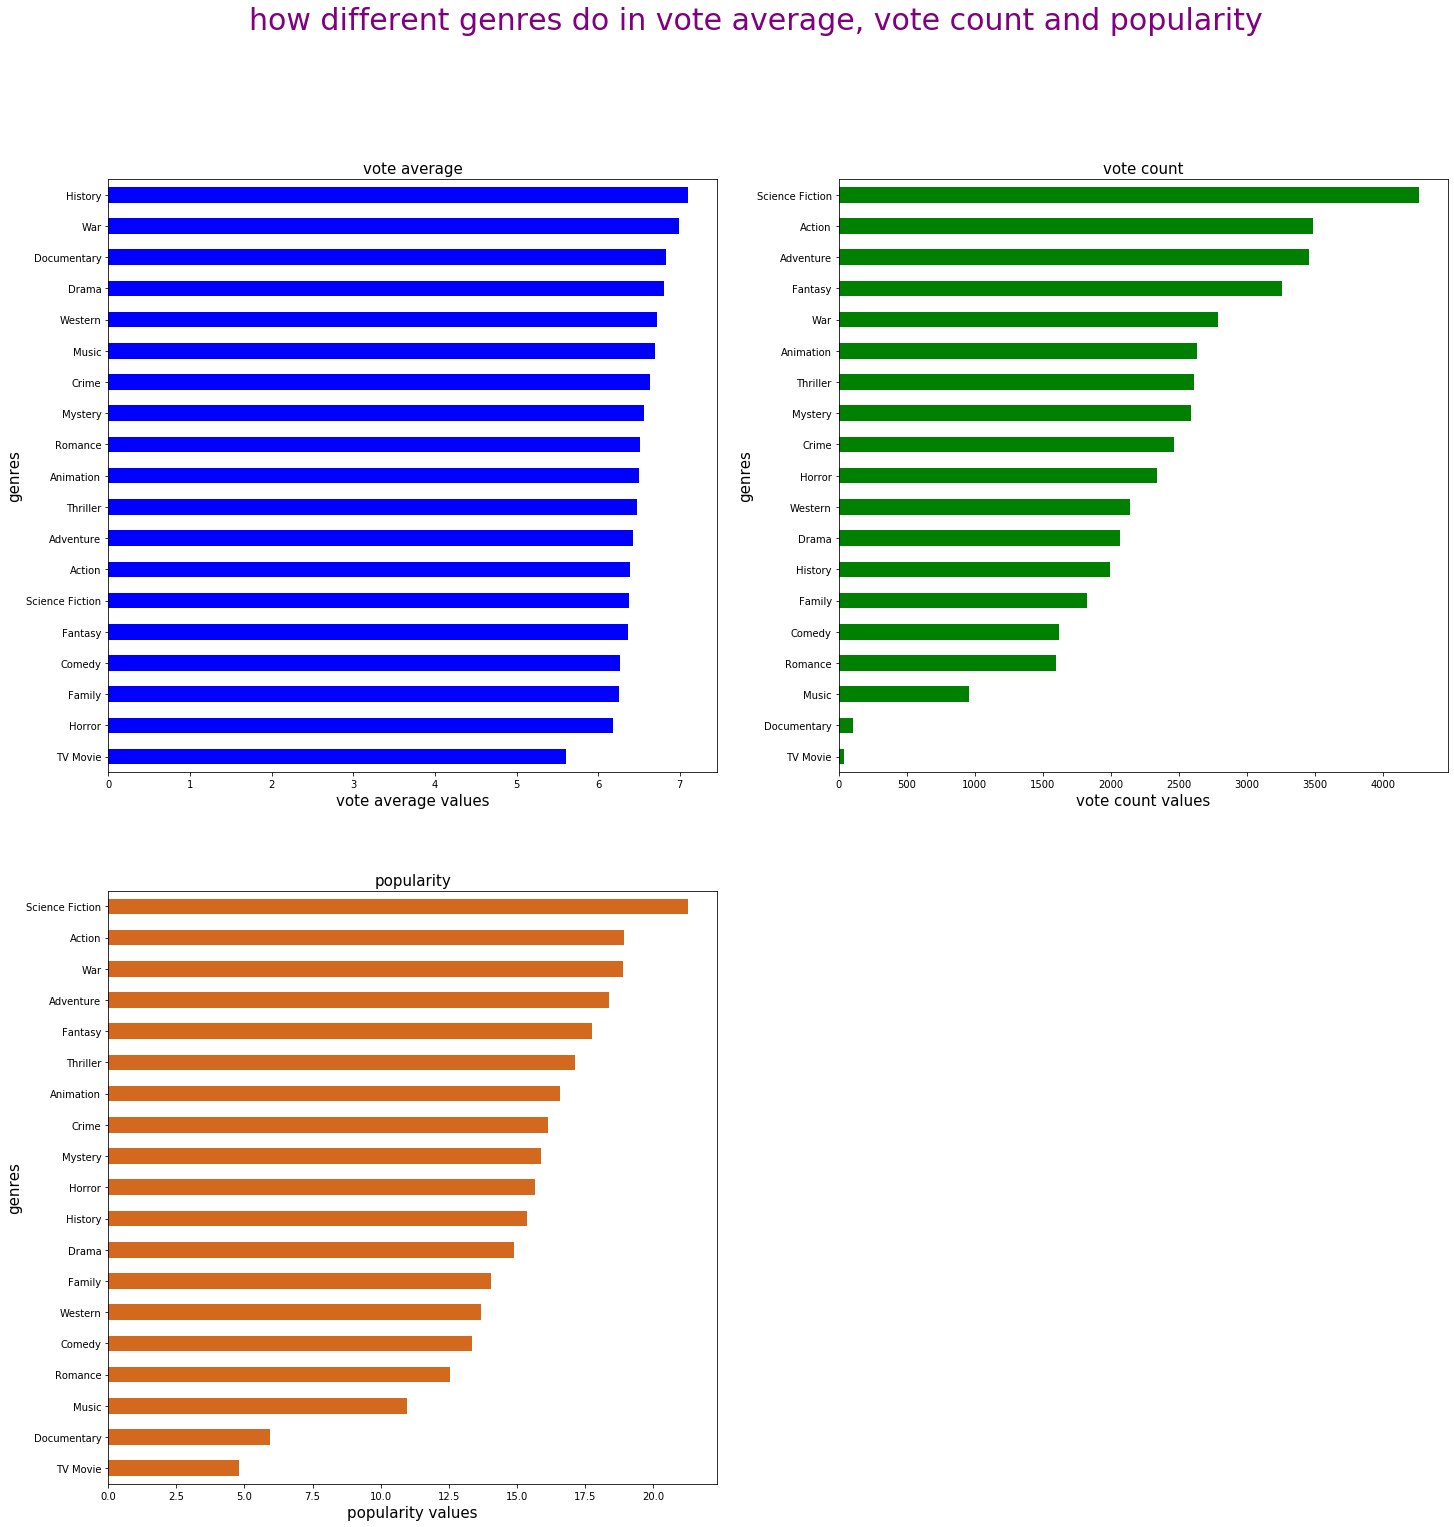

In [323]:
plt.figure(figsize = [24, 24])
plt.suptitle('how different genres do in vote average, vote count and popularity', 
             fontsize = 30, color = 'purple')

plt.subplot(2,2,1)
pd.Series(genres_dict_vote_average).sort_values().plot(kind = 'barh', color = 'blue')
plt.title('vote average', fontsize = 15)
plt.xlabel('vote average values', fontsize = 15)
plt.ylabel('genres', fontsize = 15)

plt.subplot(2,2,2)
pd.Series(genres_dict_vote_count).sort_values().plot(kind = 'barh', color = 'green')
plt.title('vote count', fontsize = 15)
plt.xlabel('vote count values', fontsize = 15)
plt.ylabel('genres', fontsize = 15)

plt.subplot(2,2,3)
pd.Series(genres_dict_popularity).sort_values().plot(kind = 'barh', color = 'chocolate')
plt.title('popularity', fontsize = 15)
plt.xlabel('popularity values', fontsize = 15)
plt.ylabel('genres', fontsize = 15)

As we can see from the above 3 graphs, genres like Science Fiction, Action, War, Adventure have the highest popularity, while genres like TV Movie, Documentary, Music have lowest popularity. This result make sense since less people watch TV Movies, Documentory, Music. 

For the vote count, we can see similar trend as popularity, Science Fiction, Action, Adventure and Fantasy has the top vote count, this also make sense since more people watch these genres. Also, TV Movies, Documentory, Music genres have least vote counts, because less people watch these hence less vote. Science Fiction definitely has most popularity from the graphs.

On the contrary, History and Documentary genres are in top 3 vote average, while Documentary is in bottom 3 in popularity & vote count and History is in lower half of popularity & vote count graphs. This also make sense since many History and Documentary movies are insightful, which enrich people's mind, leading to higher vote rating. Although these kind of movies are not very popular, but they contain depth of thinking. 

So if a company like Microsoft wants to make a film that have most popularity and wants more people to watch it, they shall choose Science Fiction, second choices could be Action or Adventure movies.

Next topic we want to look into is the Profit Margin, since most important aim for enterprise is probably to earn money

__Profit Margin__

Profit Margin is defined by (Revenue - Cost) / Revenue, this this case, we use the revenue and budget column to calculate

In [335]:
# Firstly we need to drop all the 0 values in budget coloumn and revenue column since 0 values
# does not make sense for budget & revenue, then we check if all remaining values are numeric
df_comprehensive1 = df_comprehensive[(df_comprehensive['budget'] != 0) & 
                                     (df_comprehensive['revenue'] != 0)]
print(np.issubdtype(df_comprehensive1['budget'].dtype, np.number))
print(np.issubdtype(df_comprehensive1['revenue'].dtype, np.number))

True
True


In [345]:
# Using the list of genres, we can find out all movies related to 1 genre and calculate the
# profit margin of these movies and then we average to see the mean value of the profit margin
# of movies for this genre
df_comprehensive1['profit_margin'] = (df_comprehensive1.revenue - 
                                      df_comprehensive1.budget) / df_comprehensive1.revenue

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [348]:
genres_dict_profitmargin = {}
for gen in genreslist: 
    genres_dict_profitmargin[gen] = []
    for iii in df_comprehensive1.index.tolist():
        if gen in df_comprehensive1.loc[iii, 'genres']:
            genres_dict_profitmargin[gen].append(df_comprehensive1.loc[iii, 'profit_margin'])
    genres_dict_profitmargin[gen] = np.mean(genres_dict_profitmargin[gen])
print(genres_dict_profitmargin)

{'Crime': 0.5920132360593579, 'Science Fiction': -2319.233582849412, 'Music': 0.3490360056501049, 'Western': 0.31771566026342063, 'Horror': -3554.904376911842, 'Adventure': 0.4184432380021334, 'War': 0.5467297179445471, 'Documentary': 0.42554195803520356, 'Romance': -1688.1983319498815, 'Comedy': -657.877718828321, 'History': 0.4972007215563663, 'Thriller': -2386.6730121618352, 'Family': -0.30973593713897984, 'Animation': -0.9989494081674554, 'Action': -875.8835337055541, 'TV Movie': nan, 'Drama': -925.6111919830796, 'Fantasy': -0.41916603711221756, 'Mystery': 0.5442419760349662}


We can see from the above data, some data is abnormal, it is weird to have average profit margin to be -2319 or -3554, so we check in the Data Frame to see which movies made this happen. Also, 'TV Movie' has nan value, we checked above coding, that is because the 'TV Movie' related data was dropped during the previous process. So, we will drop this in the dictionary later

In [357]:
# check the bad profit margin movies
df_comprehensive1[df_comprehensive1['profit_margin'] < -1000]

,title,rank,lifetime_gross,overall_rank,year,id,MPAA,adult,budget,genres,...,original_language,original_title,popularity,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,profit_margin
2308,Honeymoon in Vegas,948,"$35,208,854","2,423",1992,tt0104438,PG-13,False,25000000,"[Action, Comedy, Romance, Thriller]",...,en,Honeymoon in Vegas,9.004,1992-08-28,35,96,"[{'iso_639_1': 'en', 'name': 'English'}]",5.5,162,-714284.714286
3180,Dreamcatcher,820,"$33,715,436","2,511",2003,tt0285531,R,False,68000000,"[Drama, Horror, Science Fiction, Thriller]",...,en,Dreamcatcher,9.209,2003-03-21,75,136,"[{'iso_639_1': 'en', 'name': 'English'}]",5.4,1114,-906665.666667


If we set the profit margin less than -100, we can see there are some movies with revenue, and inconsistent with the lifttime_gross column, so we drop thes rows because it might have wrong input and calculate again

In [394]:
genreslist.pop(-4) # drop 'TV Movie' from the genres list for the profit margin visualization

'TV Movie'

In [395]:
df_comprehensive2 = df_comprehensive1[df_comprehensive1['profit_margin'] > -1000]
genres_dict_profitmargin = {}
for gen in genreslist: 
    genres_dict_profitmargin[gen] = []
    for iii in df_comprehensive2.index.tolist():
        if gen in df_comprehensive2.loc[iii, 'genres']:
            genres_dict_profitmargin[gen].append(df_comprehensive2.loc[iii, 'profit_margin'])
    genres_dict_profitmargin[gen] = np.mean(genres_dict_profitmargin[gen])
print(genres_dict_profitmargin)

{'Crime': 0.5920132360593579, 'Science Fiction': -0.39657494218891765, 'Music': 0.3490360056501049, 'Western': 0.31771566026342063, 'Horror': 0.6498053312870636, 'Adventure': 0.4184432380021334, 'War': 0.5467297179445471, 'Documentary': 0.42554195803520356, 'Romance': 0.4190044334465275, 'Comedy': 0.4496211780313137, 'History': 0.4972007215563663, 'Thriller': 0.5899640982195979, 'Family': -0.30973593713897984, 'Animation': -0.9989494081674554, 'Action': 0.5400912969138509, 'Drama': 0.5033841669035208, 'Fantasy': -0.41916603711221756, 'Mystery': 0.5442419760349662}


Now the data makes more sense, we can plot it!

(-1.1, 1)

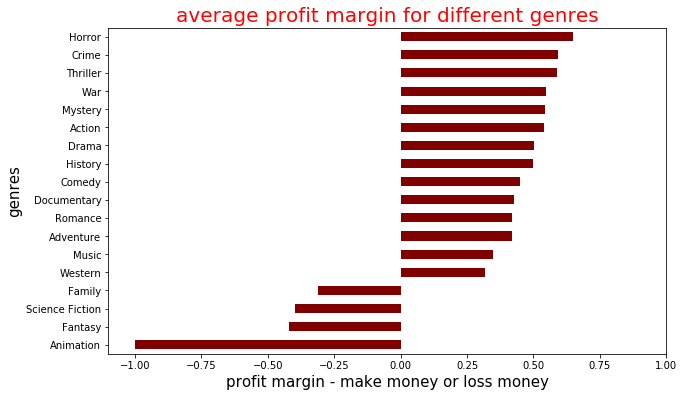

In [396]:
plt.figure(figsize = [10, 6])
pd.Series(genres_dict_profitmargin).sort_values().plot(kind = 'barh', color = 'maroon')
plt.title('average profit margin for different genres', fontsize = 20, color = 'red')
plt.xlabel('profit margin - make money or loss money', fontsize = 15)
plt.ylabel('genres', fontsize = 15)
plt.xlim(-1.1, 1)

As we can see from the above plot, most genres are averagely profitable, only 4 genres loos money. Horror, Crime and Thriller have best profit margin, we think this may be because the cost of these movies are low (low budget), although these genres are not top popular as we can see in the previous visualization. Low budget is great help for profit margin. On the other hand, we can see here Science Fiction movie usually does not make profit, this might because the cost (budget) is high, and does not make up in the revenue.

Next, we want to see what are the average budget for different genres of movies.

In [397]:
genres_dict_budget = {}
for gen in genreslist: 
    genres_dict_budget[gen] = []
    for jjj in df_comprehensive2.index.tolist():
        if gen in df_comprehensive2.loc[jjj, 'genres']:
            genres_dict_budget[gen].append(df_comprehensive2.loc[jjj, 'budget'])
    genres_dict_budget[gen] = np.mean(genres_dict_budget[gen])
genres_dict_budget

{'Crime': 43619063.44125327,
 'Science Fiction': 85210641.03333333,
 'Music': 26789890.476190478,
 'Western': 54070278.88888889,
 'Horror': 29293491.921259843,
 'Adventure': 87719834.5156038,
 'War': 53019540.22988506,
 'Documentary': 13950964.529411765,
 'Romance': 36583866.03554502,
 'Comedy': 45614826.35885609,
 'History': 50076333.333333336,
 'Thriller': 51380510.319054656,
 'Family': 64706452.64672897,
 'Animation': 75461786.28571428,
 'Action': 80330626.61179361,
 'Drama': 40779324.27811861,
 'Fantasy': 82533160.75184275,
 'Mystery': 45763842.222222224}

Text(War, 88000000.0, 'top budget')

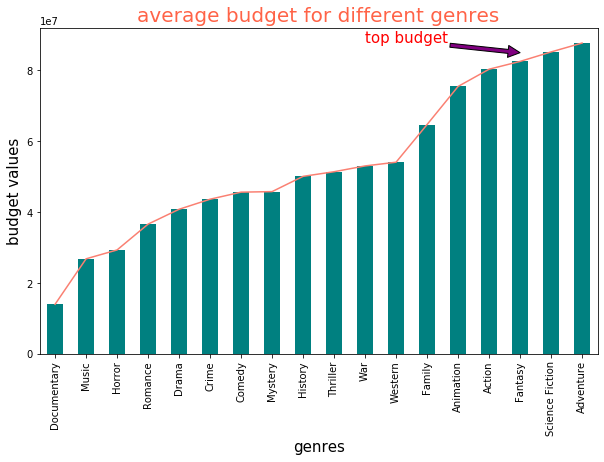

In [413]:
plt.figure(figsize = [10, 6])
pd.Series(genres_dict_budget).sort_values().plot(kind = 'bar', color = 'teal')
plt.plot(pd.Series(genres_dict_budget).sort_values(), color = 'salmon')
plt.title('average budget for different genres', fontsize = 20, color = 'tomato')
plt.ylabel('budget values', fontsize = 15)
plt.xlabel('genres', fontsize = 15)
plt.annotate('top budget', xy=('Fantasy', 85e6), arrowprops = dict(facecolor = 'purple'),
             xytext = ('War', 88e6), color = 'red', fontsize = 15)

This budget chart can confirm the previous discussion. We can see here Adventure, Science Fiction, Fantasy, Action and Animation consumes significant higher budget than other genres, while 3 of them (Science Fiction, Fantasy, Animation) are all in the negative side of the profit margin graph. 

We can also see that for the top 3 profit margin genres (Horror, Crime, Thriller), Horror is also one of the genres with lowest average budget. Crime genre also lays in the lower half in the budget chart. Thriller is at the middle of the budget chart. 

While we cannot say the low budget definitely makes high profit margin, we realize that control budget is important for a company to make money!

__Runtime__

Next we want to check if runtime has influence on the popularity and profit margin of movies

In [416]:
import seaborn as sns

Text(0.5, 1, 'is there relationship between runtime and profit margin?')

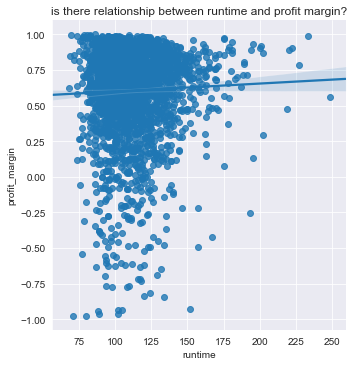

In [431]:
sns.set_style('darkgrid')
sns.lmplot(x = 'runtime', y ='profit_margin', 
           data = df_comprehensive2[df_comprehensive2.profit_margin > -1])
plt.title('is there relationship between runtime and profit margin?')

From the above graph, we can know there is distinct relationship between runtime and profit margin of movies

Text(0.5, 1, 'popularity vs runtime')

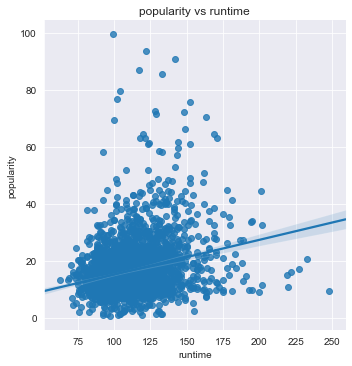

In [433]:
sns.lmplot(x = 'runtime', y ='popularity', 
           data = df_comprehensive2[df_comprehensive2.popularity < 100])
plt.title('popularity vs runtime')

Text(0, 0.5, 'popularity')

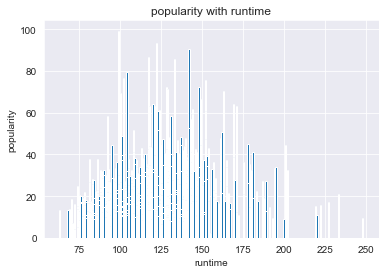

In [441]:
plt.bar(df_comprehensive2[df_comprehensive2.popularity < 100].runtime, 
         df_comprehensive2[df_comprehensive2.popularity < 100].popularity)
plt.title('popularity with runtime')
plt.xlabel('runtime')
plt.ylabel('popularity')

Text(0, 0.5, 'profit margin')

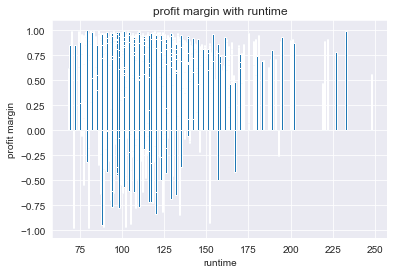

In [442]:
plt.bar(df_comprehensive2[df_comprehensive2.profit_margin > -1].runtime,
        df_comprehensive2[df_comprehensive2.profit_margin > -1].profit_margin)
plt.title('profit margin with runtime')
plt.xlabel('runtime')
plt.ylabel('profit margin')

As we can see from the above 2 plots, most popular movies are in the 90 minutes - 200 minites range. Within this range, popularity slowly increase as the runtime increase 

__Different MPAA Ratings__

We can also see what is the revenue for different MPAA ratings

In [460]:
# the values in overall_rank column in df_comprehensive is strings, need to eliminate the
# comma inside and change them to integers
Series_overall_rank = df_comprehensive.overall_rank.map(lambda x: x.replace(',','')).map(lambda y: int(y))
Series_overall_rank

0         24
1         28
2         30
3         43
4        101
        ... 
3356    2911
3357    2912
3358    2914
3359    2916
3360    2922
Name: overall_rank, Length: 3361, dtype: int64

In [463]:
# reset the 'overall_rank' column
df_comprehensive['overall_rank'] = Series_overall_rank

In [464]:
df_comprehensive

,title,rank,lifetime_gross,overall_rank,year,id,MPAA,adult,budget,genres,imdb_id,original_language,original_title,popularity,release_date,revenue,runtime,spoken_languages,vote_average,vote_count
0,Toy Story 4,1,"$434,038,008",24,2019,tt1979376,G,False,175000000,"[Adventure, Animation, Comedy, Family, Fantasy]",tt1979376,en,Toy Story 4,34.489,2019-06-19,1073394593,100,"[{'iso_639_1': 'en', 'name': 'English'}]",7.6,5029
1,The Lion King,2,"$422,783,777",28,1994,tt0110357,G,False,45000000,"[Family, Animation, Drama]",tt0110357,en,The Lion King,32.284,1994-05-07,987483777,89,"[{'iso_639_1': 'en', 'name': 'English'}]",8.3,12393
2,Toy Story 3,3,"$415,004,880",30,2010,tt0435761,G,False,200000000,"[Animation, Family, Comedy]",tt0435761,en,Toy Story 3,27.214,2010-06-16,1066969703,103,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",7.8,10168
3,Finding Nemo,4,"$380,843,261",43,2003,tt0266543,G,False,94000000,"[Animation, Family]",tt0266543,en,Finding Nemo,34.417,2003-05-30,940335536,100,"[{'iso_639_1': 'en', 'name': 'English'}]",7.8,13547
4,"Monsters, Inc.",5,"$289,916,256",101,2001,tt0198781,G,False,115000000,"[Animation, Comedy, Family]",tt0198781,en,"Monsters, Inc.",41.313,2001-11-01,562816256,92,"[{'iso_639_1': 'en', 'name': 'English'}]",7.8,12668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356,Three Days of the Condor,996,"$27,476,252",2911,1975,tt0073802,R,False,0,[Thriller],tt0073802,en,Three Days of the Condor,11.005,1975-09-24,27476252,117,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",7.3,573
3357,Friday,997,"$27,467,564",2912,1995,tt0113118,R,False,3500000,[Comedy],tt0113118,en,Friday,10.221,1995-04-26,28215918,91,"[{'iso_639_1': 'en', 'name': 'English'}]",7.1,968
3358,The Brothers,998,"$27,457,409",2914,2001,tt0250274,R,False,0,"[Comedy, Drama, Romance]",tt0250274,en,The Brothers,4.534,2001-03-23,0,106,"[{'iso_639_1': 'en', 'name': 'English'}]",7.0,21
3359,Midsommar,999,"$27,426,361",2916,2019,tt8772262,R,False,9000000,"[Horror, Drama, Mystery]",tt8772262,en,Midsommar,29.161,2019-07-03,46890297,148,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",7.1,2376


In [466]:
df_comprehensive.sort_values(by = 'overall_rank')

,title,rank,lifetime_gross,overall_rank,year,id,MPAA,adult,budget,genres,imdb_id,original_language,original_title,popularity,release_date,revenue,runtime,spoken_languages,vote_average,vote_count
1361,Star Wars: Episode VII - The Force Awakens,1,"$936,662,225",1,2015,tt2488496,PG-13,False,245000000,"[Action, Adventure, Science Fiction, Fantasy]",tt2488496,en,Star Wars: The Force Awakens,40.452,2015-12-15,2068223624,136,"[{'iso_639_1': 'en', 'name': 'English'}]",7.4,14469
1362,Avengers: Endgame,2,"$858,373,000",2,2019,tt4154796,PG-13,False,356000000,"[Adventure, Science Fiction, Action]",tt4154796,en,Avengers: Endgame,41.244,2019-04-24,2797800564,181,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",8.3,13314
1363,Avatar,3,"$760,507,625",3,2009,tt0499549,PG-13,False,237000000,"[Action, Adventure, Fantasy, Science Fiction]",tt0499549,en,Avatar,40.099,2009-12-10,2787965087,162,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",7.4,21344
1364,Black Panther,4,"$700,059,566",4,2018,tt1825683,PG-13,False,200000000,"[Action, Adventure, Fantasy, Science Fiction]",tt1825683,en,Black Panther,41.152,2018-02-13,1346739107,134,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",7.4,15135
1365,Avengers: Infinity War,5,"$678,815,482",5,2018,tt4154756,PG-13,False,300000000,"[Adventure, Action, Science Fiction]",tt4154756,en,Avengers: Infinity War,66.376,2018-04-25,2046239637,149,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",8.3,18257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,Wa-shoku Dream: Beyond Sushi,357,"$12,240",15209,2015,tt3846402,G,False,0,"[Family, Documentary]",tt3846402,en,Wa-shoku ~Beyond Sushi~,2.743,2015-04-24,0,107,"[{'iso_639_1': 'ja', 'name': '日本語'}, {'iso_639...",6.0,1
357,Mr. Chibbs,358,"$8,302",15729,2017,tt4633340,G,False,0,[],tt4633340,en,Mr. Chibbs,1.315,2017-05-03,0,86,"[{'iso_639_1': 'en', 'name': 'English'}]",5.7,3
358,Boom Bust Boom,359,"$6,896",15959,2016,tt3332308,G,False,0,"[History, Documentary]",tt3332308,en,Boom Bust Boom,4.974,2016-03-11,0,74,"[{'iso_639_1': 'en', 'name': 'English'}]",6.6,7
359,School of Life,360,"$6,300",16049,2018,tt6330246,G,False,0,"[Drama, Comedy, Family]",tt6330246,fr,L'École Buissonnière,7.333,2017-02-22,0,116,"[{'iso_639_1': 'fr', 'name': 'Français'}]",7.2,140


Text(0, 0.5, 'counts of each MPAA rating')

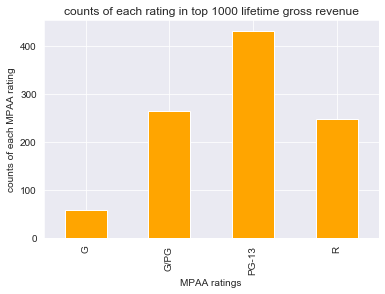

In [481]:
df_comprehensive[df_comprehensive['overall_rank']<=1000].groupby('MPAA').count().overall_rank.plot(kind = 'bar', color = 'orange')
plt.title('counts of each rating in top 1000 lifetime gross revenue')
plt.xlabel('MPAA ratings')
plt.ylabel('counts of each MPAA rating')

From the plot above, we can see almost half of the top 1000 lifetime gross revenue movies are PG-13 rating, while R rating only has around 50 counts (5%).

__Does the release date of movie affect the profit?__

It is well known that release date of movie is important, we would like to make simple analysis of this point based on the data we have. We firstly separate by seasons and then by months. 

In [486]:
seasonlist = ['-03-04-05', '-06-07-08', '-09-10-11', '-12-01-02']
season_dict_profitmargin = {}
for season in seasonlist: 
    season_dict_profitmargin[season] = []
    for kkk in df_comprehensive2.index.tolist():
        if df_comprehensive2.loc[kkk,'release_date'][4:7] in [season[:3],season[3:6],season[6:]]:
            season_dict_profitmargin[season].append(df_comprehensive2.loc[kkk, 'profit_margin'])
    season_dict_profitmargin[season] = np.mean(season_dict_profitmargin[season])
print(season_dict_profitmargin)

{'-03-04-05': 0.5364334740977945, '-06-07-08': 0.5363264487857963, '-09-10-11': -0.009084921219630386, '-12-01-02': 0.4317870085591559}


(-0.1, 0.7)

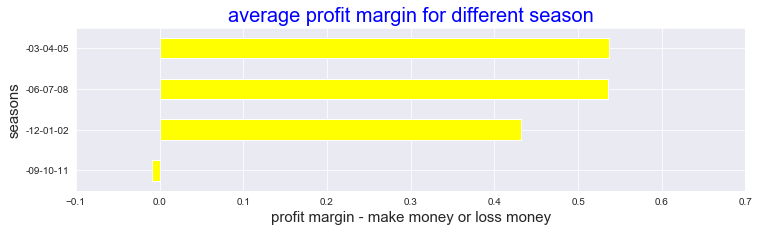

In [494]:
plt.figure(figsize = [12, 3])
pd.Series(season_dict_profitmargin).sort_values().plot(kind = 'barh', color = 'yellow')
plt.title('average profit margin for different season', fontsize = 20, color = 'blue')
plt.xlabel('profit margin - make money or loss money', fontsize = 15)
plt.ylabel('seasons', fontsize = 15)
plt.xlim(-0.1, 0.7)

In [495]:
monthlist = ['-03','-04','-05','-06','-07','-08','-09','-10','-11','-12','-01','-02']
month_dict_profitmargin = {}
for month in monthlist: 
    month_dict_profitmargin[month] = []
    for xxx in df_comprehensive2.index.tolist():
        if df_comprehensive2.loc[xxx,'release_date'][4:7] == month:
            month_dict_profitmargin[month].append(df_comprehensive2.loc[xxx, 'profit_margin'])
    month_dict_profitmargin[month] = np.mean(month_dict_profitmargin[month])
print(month_dict_profitmargin)

{'-03': 0.4761789352679441, '-04': 0.4749037703119798, '-05': 0.6451149041668479, '-06': 0.5771460733780024, '-07': 0.5272308271672399, '-08': 0.48723672051676165, '-09': 0.3629910614501437, '-10': -0.9366669276356036, '-11': 0.5552276947937722, '-12': 0.5550758818729711, '-01': 0.6231205119560943, '-02': 0.04826320264901964}


__We have run more data visualizations for movies net profit of movies by year, by MPAA rating, by runtime, etc. Please refer to other jupyter notebook files for more analysis and visualizations in project repositary__